In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline



In [2]:

# Charger les données
data = pd.read_csv('financials.csv')
data = data.dropna()
data.isnull().sum()


Symbol            0
Name              0
Sector            0
Price             0
Price/Earnings    0
Dividend Yield    0
Earnings/Share    0
52 Week Low       0
52 Week High      0
Market Cap        0
EBITDA            0
Price/Sales       0
Price/Book        0
SEC Filings       0
dtype: int64

In [3]:
#data = data.drop(['Project Links', 'Project Start Date', 'Project Expiration Date'], axis=1)
X = data[["Price/Earnings", "Dividend Yield", "Earnings/Share", "52 Week Low", "52 Week High","Market Cap","EBITDA","Price/Sales","Price/Book"]]
X

,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
0,24.31,2.332862,7.92,259.77,175.490,1.387211e+11,9.048000e+09,4.390271,11.34
1,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35
2,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19
3,19.41,2.499560,3.29,125.86,60.050,1.813863e+11,1.031000e+10,6.291571,26.14
4,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62
...,...,...,...,...,...,...,...,...,...
500,30.94,1.170079,1.83,76.81,46.860,1.291502e+10,7.220000e+08,2.726209,5.31
501,27.25,1.797080,4.07,86.93,62.850,2.700330e+10,2.289000e+09,6.313636,212.08
502,14.32,0.794834,9.01,133.49,108.170,2.445470e+10,2.007400e+09,3.164895,2.39
503,17.73,1.480933,2.60,55.61,38.430,1.067068e+10,0.000000e+00,3.794579,1.42


In [4]:
def classify_performance(row):
    if row['Price/Earnings'] < 20:
        return 'bonne'
    elif 20 <= row['Price/Earnings'] <= 50:
        return 'moyenne'
    else:
        return 'faible'

data['performance'] = data.apply(classify_performance, axis=1)
y=data['performance']

In [5]:
# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
# Diviser les données en ensembles d'entraînement et de test avec les données normalisées
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


In [7]:
# Mettre en place un pipeline pour intégrer normalisation et GridSearchCV
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(random_state=42))
])



In [8]:
# Ajuster les hyperparamètres avec GridSearchCV dans le pipeline
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False]
}


In [9]:
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)



Fitting 3 folds for each of 162 candidates, totalling 486 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__bootstrap': [True, False],
                         'classifier__max_depth': [10, 20, 30],
                         'classifier__min_samples_leaf': [1, 2, 4],
                         'classifier__min_samples_split': [2, 5, 10],
                         'classifier__n_estimators': [100, 200, 300]},
             verbose=2)

In [10]:
# Afficher les meilleurs hyperparamètres trouvés
print(f"Meilleurs paramètres : {grid_search.best_params_}")

# Utiliser le meilleur modèle trouvé par GridSearchCV
best_model = grid_search.best_estimator_

# Prédictions sur l'ensemble de test
y_pred = best_model.predict(X_test)



Meilleurs paramètres : {'classifier__bootstrap': False, 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 100}


In [11]:
# Évaluer le modèle
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision du modèle : {accuracy:.4f}")
print("\nRapport de classification :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)



Précision du modèle : 0.9597

Rapport de classification :
              precision    recall  f1-score   support

       bonne       0.99      1.00      0.99        78
      faible       1.00      0.50      0.67        10
     moyenne       0.92      0.98      0.95        61

    accuracy                           0.96       149
   macro avg       0.97      0.83      0.87       149
weighted avg       0.96      0.96      0.95       149



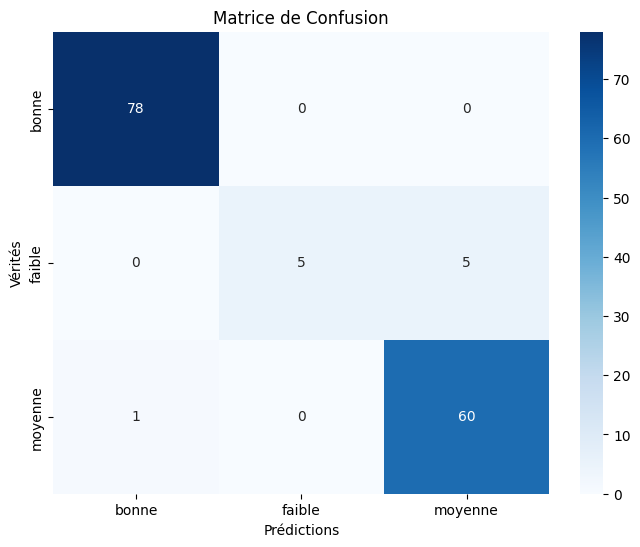

In [12]:
# Visualiser la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.title("Matrice de Confusion")
plt.xlabel("Prédictions")
plt.ylabel("Vérités")
plt.show()



In [13]:
# Visualiser l'importance des caractéristiques
feature_importances = best_model.named_steps['classifier'].feature_importances_
features = X.columns


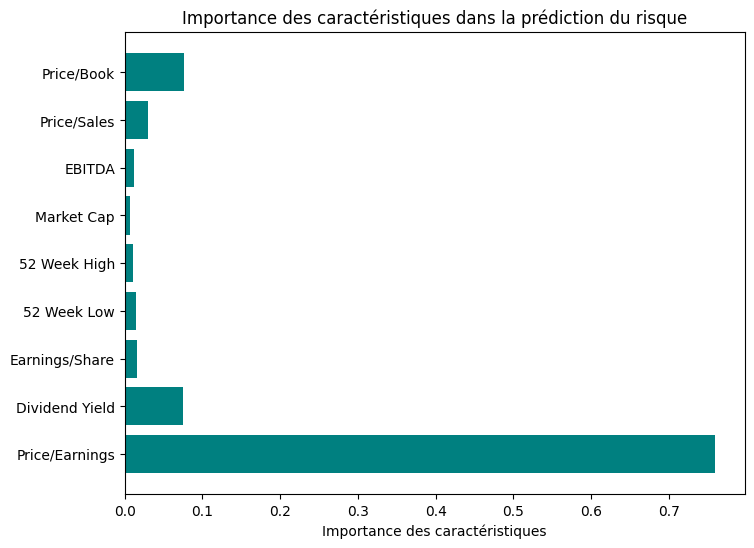

In [14]:
# Créer un graphique des importances des caractéristiques
plt.figure(figsize=(8, 6))
plt.barh(features, feature_importances, color='teal')
plt.xlabel('Importance des caractéristiques')
plt.title('Importance des caractéristiques dans la prédiction du risque')
plt.show()